In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Final_GTSRB.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Final_GTSRB.zip')
f.keys()
!unzip Final_GTSRB.zip

Streaming output truncated to the last 5000 lines.
  inflating: Final_GTSRB/train/00038/00001.jpg  
  inflating: Final_GTSRB/train/00038/00002.jpg  
  inflating: Final_GTSRB/train/00038/00003.jpg  
  inflating: Final_GTSRB/train/00038/00004.jpg  
  inflating: Final_GTSRB/train/00038/00005.jpg  
  inflating: Final_GTSRB/train/00038/00006.jpg  
  inflating: Final_GTSRB/train/00038/00007.jpg  
  inflating: Final_GTSRB/train/00038/00008.jpg  
  inflating: Final_GTSRB/train/00038/00009.jpg  
  inflating: Final_GTSRB/train/00038/00010.jpg  
  inflating: Final_GTSRB/train/00038/00011.jpg  
  inflating: Final_GTSRB/train/00038/00012.jpg  
  inflating: Final_GTSRB/train/00038/00013.jpg  
  inflating: Final_GTSRB/train/00038/00014.jpg  
  inflating: Final_GTSRB/train/00038/00015.jpg  
  inflating: Final_GTSRB/train/00038/00016.jpg  
  inflating: Final_GTSRB/train/00038/00017.jpg  
  inflating: Final_GTSRB/train/00038/00018.jpg  
  inflating: Final_GTSRB/train/00038/00019.jpg  
  inflating: Final

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.14.0


In [ ]:
dataset = '/content/Final_GTSRB/train'

test_dir ='/content/Final_GTSRB/test'

BATCH_SIZE = 32
IMG_SIZE = (96, 96)


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='training',
                                                                 seed=66)
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='validation',
                                                                 seed=66)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 42998 files belonging to 43 classes.
Using 34399 files for training.
Found 42998 files belonging to 43 classes.
Using 8599 files for validation.
Found 12630 files belonging to 43 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),

        layers.RandomZoom(height_factor=0.1, width_factor=0.1),

        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images

    ]
)


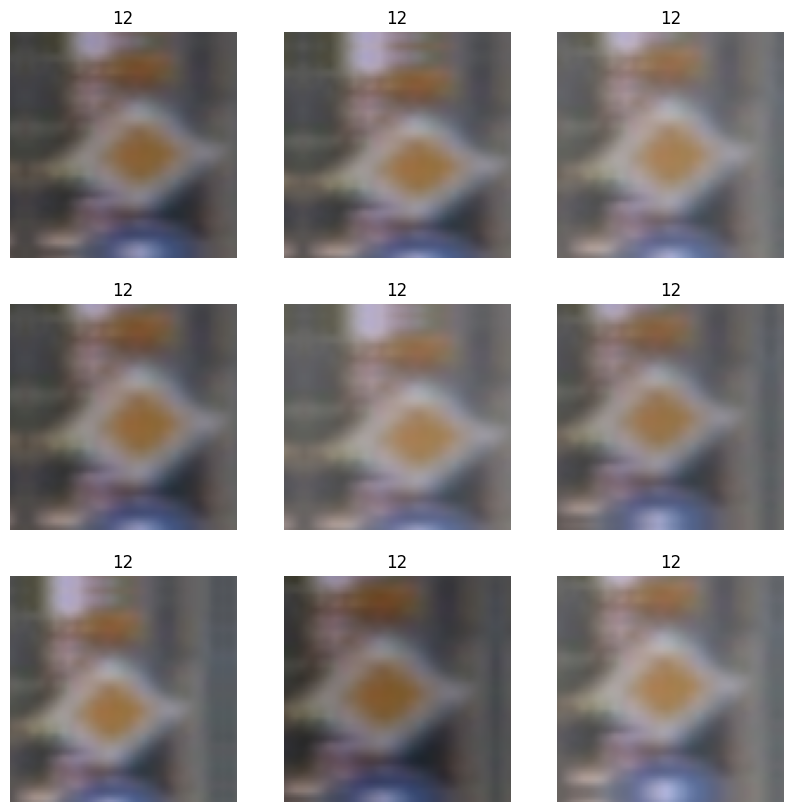

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.ResNet50 (
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
nb_classes = 43
inputs = keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)
outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

modelF = model

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
1075/1075 [==============================] - 70s 51ms/step - loss: 3.1766 - accuracy: 0.1450 - val_loss: 2.6260 - val_accuracy: 0.2576
Epoch 2/100
1075/1075 [==============================] - 45s 42ms/step - loss: 2.7223 - accuracy: 0.2342 - val_loss: 2.3384 - val_accuracy: 0.3486
Epoch 3/100
1075/1075 [==============================] - 42s 39ms/step - loss: 2.5370 - accuracy: 0.2803 - val_loss: 2.1403 - val_accuracy: 0.3991
Epoch 4/100
1075/1075 [==============================] - 42s 39ms/step - loss: 2.4148 - accuracy: 0.3070 - val_loss: 2.0086 - val_accuracy: 0.4323
Epoch 5/100
1075/1075 [==============================] - 41s 38ms/step - loss: 2.3429 - accuracy: 0.3259 - val_loss: 1.9220 - val_accuracy: 0.4530
Epoch 6/100
1075/1075 [==============================] - 41s 38ms/step - loss: 2.2777 - accuracy: 0.3394 - val_loss: 1.8757 - val_accuracy: 0.4558
Epoch 7/100
1075/1075 [==============================] - 41s 38ms/step - loss: 2.2336 - accuracy: 0.3516 - val_loss: 1

In [ ]:
scores = model.evaluate(test_dataset)

395/395 [==============================] - 10s 26ms/step - loss: 2.3814 - accuracy: 0.3988


In [ ]:
modelF.trainable = True
modelF.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
modelF.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:
epochs = 100
modelF.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
1075/1075 [==============================] - 168s 108ms/step - loss: 2.0286 - accuracy: 0.4050 - val_loss: 1.0148 - val_accuracy: 0.6660
Epoch 2/100
1075/1075 [==============================] - 110s 102ms/step - loss: 1.1725 - accuracy: 0.6241 - val_loss: 0.6410 - val_accuracy: 0.7908
Epoch 3/100
1075/1075 [==============================] - 110s 103ms/step - loss: 0.7973 - accuracy: 0.7421 - val_loss: 0.3869 - val_accuracy: 0.8746
Epoch 4/100
1075/1075 [==============================] - 111s 103ms/step - loss: 0.5581 - accuracy: 0.8196 - val_loss: 0.2382 - val_accuracy: 0.9192
Epoch 5/100
1075/1075 [==============================] - 115s 107ms/step - loss: 0.4085 - accuracy: 0.8709 - val_loss: 0.1514 - val_accuracy: 0.9546
Epoch 6/100
1075/1075 [==============================] - 110s 102ms/step - loss: 0.3032 - accuracy: 0.9056 - val_loss: 0.1407 - val_accuracy: 0.9588
Epoch 7/100
1075/1075 [==============================] - 110s 102ms/step - loss: 0.2388 - accuracy: 0.9252

In [ ]:
scores = modelF.evaluate(test_dataset)

395/395 [==============================] - 10s 25ms/step - loss: 0.2537 - accuracy: 0.9386


In [ ]:
class_names = validation_dataset.class_names
class_names

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042']

In [ ]:
def predict(modelF, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = modelF.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


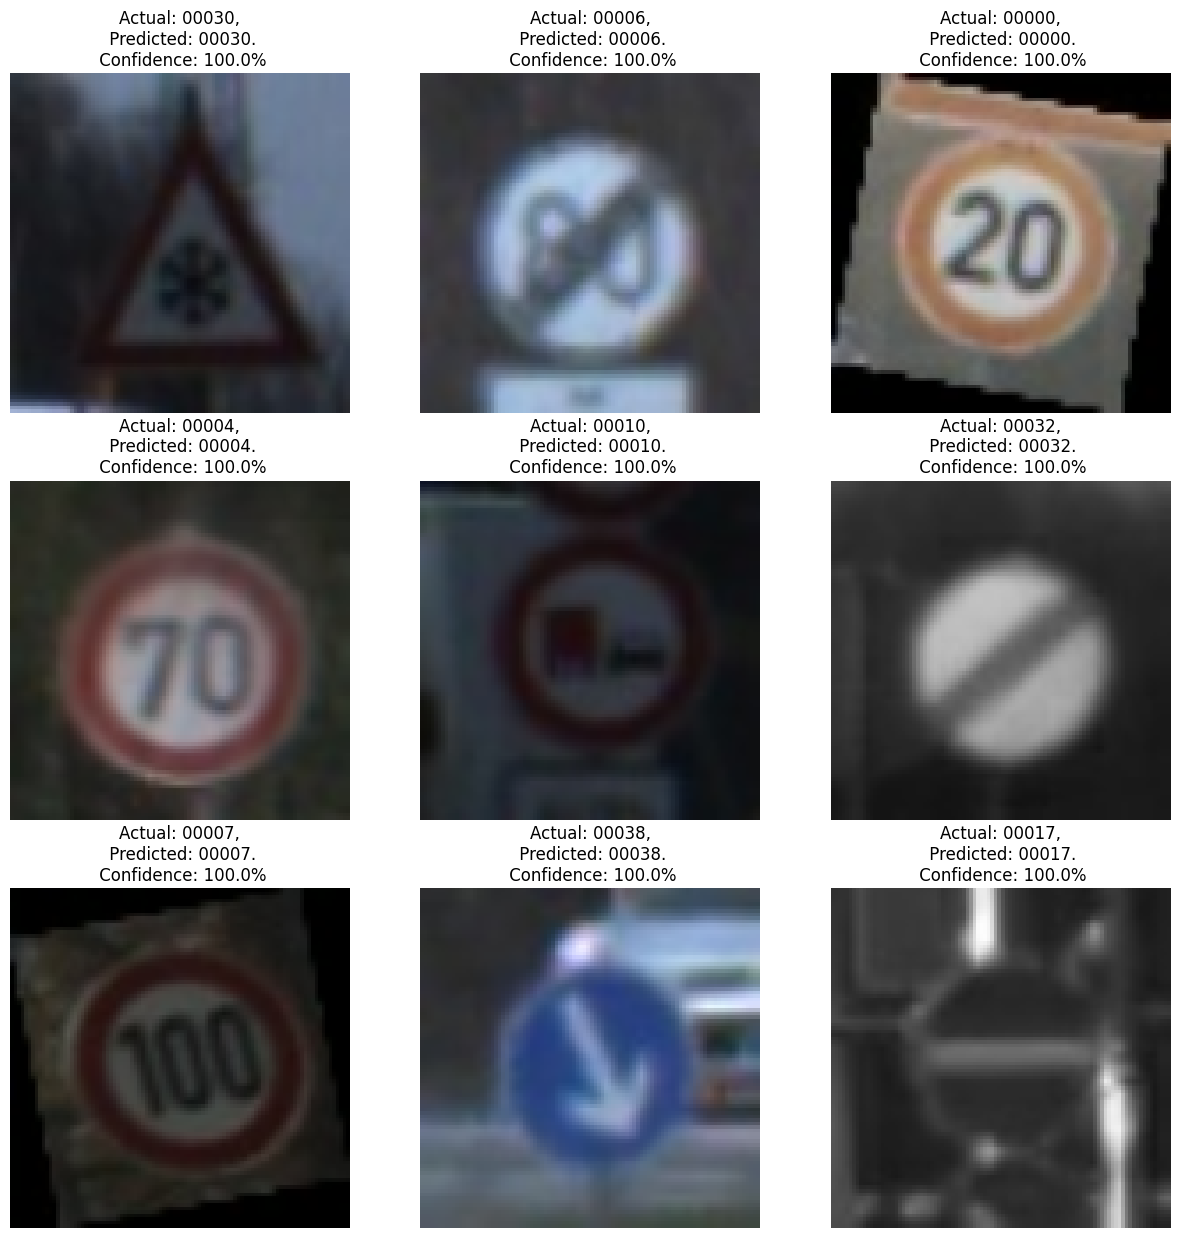

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(modelF, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 42ms/step


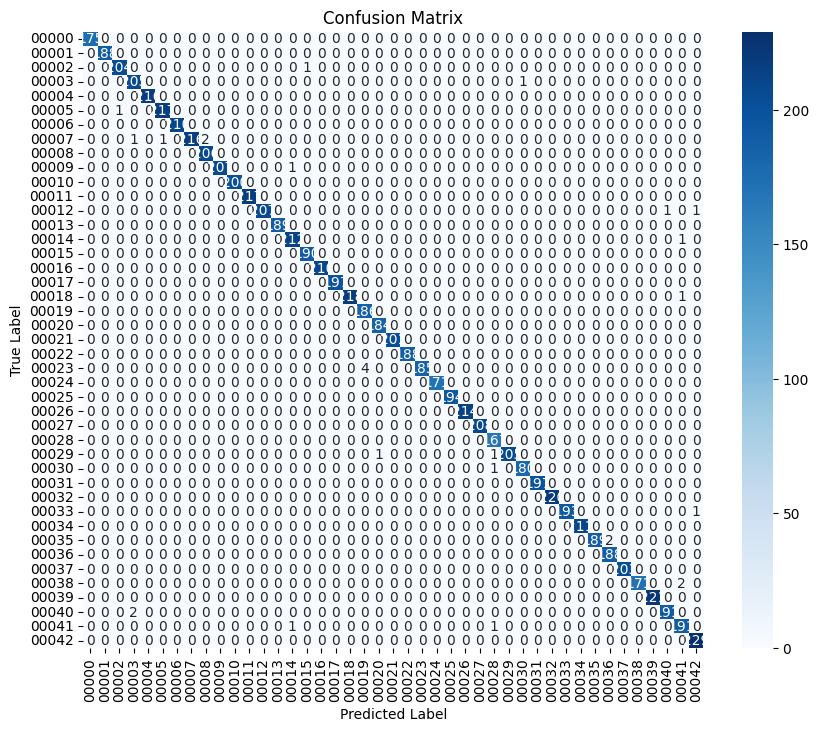

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step
F1 Score: 0.996693738808779
Precision: 0.9966832442151398
Recall: 0.9967348336679105
ROC-AUC Score: 0.999997079605734


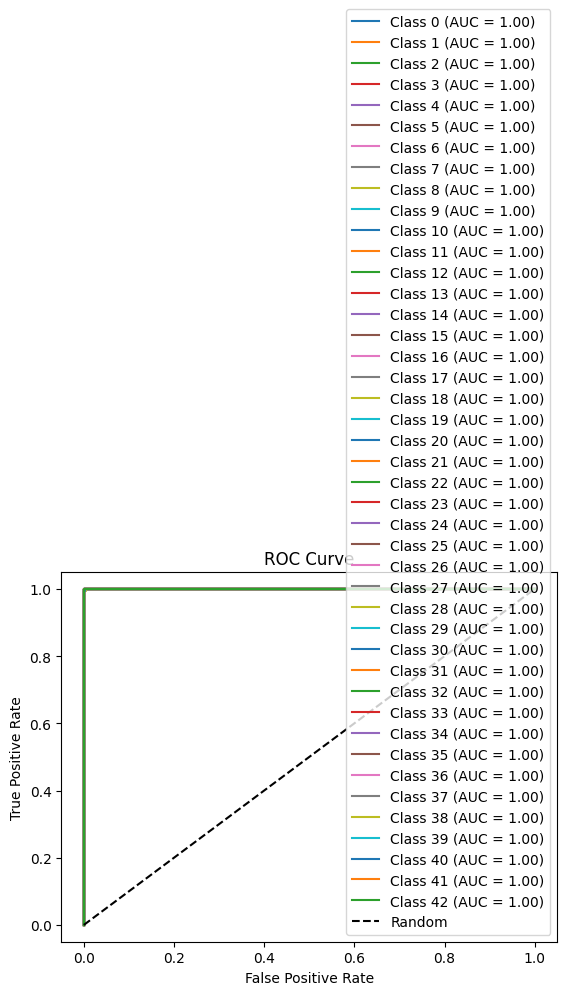

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in validation_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step
F1 Score: 0.996693738808779
Precision: 0.9966832442151398
Recall: 0.9967348336679105
ROC-AUC Score: 0.999997079605734


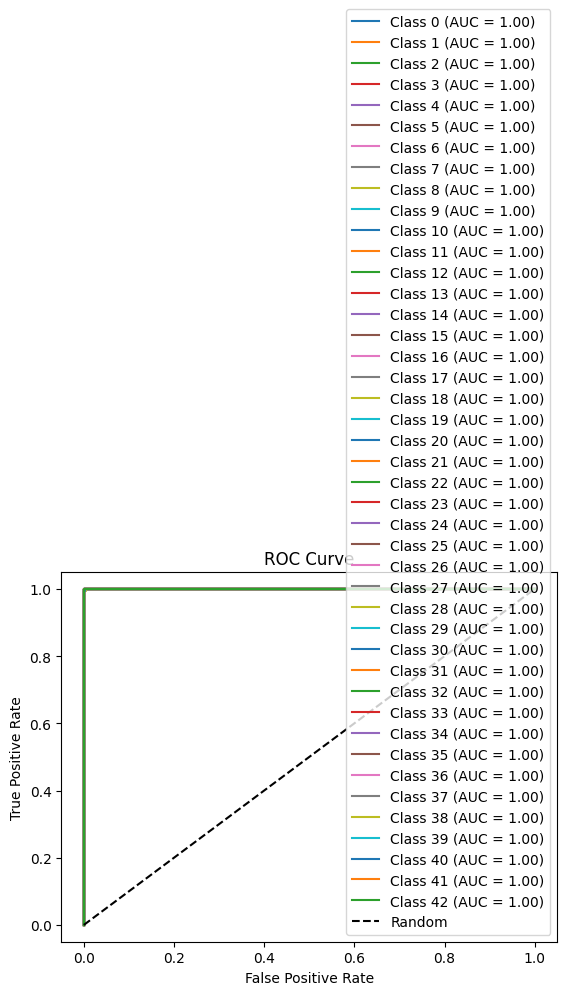

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in validation_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(modelF.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 106s 106s/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(modelF.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()